In [14]:
import numpy as np
import pandas as pd
import scanpy as sc

from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib

import brokenaxes
from brokenaxes import brokenaxes as brokax
from matplotlib.gridspec import GridSpec
import sklearn
import uncertainties
import os
import scipy

import string

from pathlib import Path
import matplotlib.patches as mpatches

import Utils as ut
import Models as mod
%matplotlib inline

AEs_order=["GRAE","TAE","AE","VAE","PeakVI","scVI","siVAE","PCA"]
new_colors=[ut.colors_to_use_pastel[4], ut.colors_to_use_pastel[1], ut.colors_to_use_pastel[6], ut.colors_to_use_pastel[2], 
ut.colors_to_use_pastel[3], ut.colors_to_use_pastel[0], ut.colors_to_use_bright[1], ut.colors_to_use_pastel[8]]
palette = {AEs_order[i] : new_colors[i] for i in range(len(AEs_order))} 
fs_order=["Peaks","GEX","Windows"]
feats_palette = {fs_order[i] : ut.colors_to_use_bright[9:12][i] for i in range(len(fs_order))}

# JOBS

In [ ]:
datasets=["10XhsBrain3kMO", "10XhsBrain3kMO","Kidney", "10XhsPBMC10kMO","10XhsPBMC10kMO", "MouseBrain"]
featurespaces=["Peak","GEX","Peak", "Peak", "GEX", "Peak"]
jobs=["BrP", "BrG", "KiP", "PbP", "PbG", "MbP"]

In [ ]:
for dataset, featurespace, job in zip(datasets, featurespaces, jobs):
    print(dataset, featurespace, job)
    matrix=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_MS.h5ad"
    for rep in AEs_order:
        for gnn in ["GAT","GCN"]:  
            path=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/MS"
            name=f"{dataset}_{featurespace}_{rep}_{gnn}"
            os.system(f"sbatch -p slim18 -J Cl{job}{gnn[1:2]}{rep[:2]} --mem=40G --ntasks=1 --cpus-per-task=6 --time 7-00:00:00\
                        --output=Datasets/{dataset}/Out/{dataset}_{featurespace}_MS_{rep}_{gnn}.out \
                       Run_Exp.sh MS {matrix} {path} {name} {rep} {gnn}")

In [ ]:
dataset="GSE117309"
featurespace="Window"
rep="GRAE"
gnn="GAT"
job="Bc"
matrix=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_MS.h5ad"
path=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/MS"
name=f"{dataset}_{featurespace}_{rep}_{gnn}"
start=1
print(f"sbatch -p slim18 -J Cl{job}{gnn[:2]}{rep} --mem=50G --ntasks=1 --cpus-per-task=10 --output=Datasets/{dataset}/Out/{dataset}_{featurespace}_MS_{rep}_{gnn}.out Run_Exp.sh MS {matrix} {path} {name} {rep} {gnn} {start}")

# Metrics

In [ ]:
datasets=["10XhsBrain3kMO", "10XhsBrain3kMO","Kidney", "10XhsPBMC10kMO","10XhsPBMC10kMO", "MouseBrain"]
featurespaces=["Peak","GEX","Peak", "Peak", "GEX", "Peak"]
jobs=["BrP", "BrG", "KiP", "PbP", "PbG", "MbP"]
lab="CellType"

In [ ]:
tot=pd.DataFrame(columns=["Representation","GNN","Accuracy","Precision","Recall","F1W","F1M","Dataset","FeaturesSpace"])
for ds, fs, nm in zip(datasets, featurespaces, jobs):
    data=pd.DataFrame(columns=tot.columns)
    for gnn in ["GAT","GCN"]:
        for rep in AEs_order:
            for run in range(0,50):
                file=f"Datasets/{ds}/FeatureSpaces/{fs}/MS/Run{run}/{ds}_{fs}_{rep}_{gnn}_Predictions.tsv.gz"
                if os.path.isfile(file) == True:               
                    df=pd.read_csv(file, sep="\t", index_col=0)
                    df=df[df["GNN_set"]=="Test"]
                    acc=np.around(df[df[lab]==df["GNN_prediction"]].shape[0]/df.shape[0], decimals=4)
                    f1=sklearn.metrics.precision_recall_fscore_support(df[lab], df.GNN_prediction, average="weighted")
                    f1m=sklearn.metrics.precision_recall_fscore_support(df[lab], df.GNN_prediction, average="macro")[2]
                    to_append=pd.DataFrame(index=data.columns, data=[rep, gnn, acc] + [f for f in np.array(f1[:3])]+[f1m, nm, fs]).T
                    data=pd.concat([data, to_append])
                else:
                    print(file)  
    tot=pd.concat([tot, data])
tot["F1W"]=tot["F1W"].astype(float)
tot["F1M"]=tot["F1M"].astype(float)
tot["Accuracy"]=tot["Accuracy"].astype(float)
tot["Precision"]=tot["Precision"].astype(float)
tot["Recall"]=tot["Recall"].astype(float)
tot.reset_index(inplace=True)
tot.drop("index", axis=1, inplace=True)
tot.to_csv("Tables/ClassficationMetrics.tsv.gz", sep="\t", index=None, compression="gzip")
tot.head()

In [ ]:
tot=pd.DataFrame(columns=["GNN","Representation","celltype","Stability","Dataset","FeaturesSpace"])
for ds, fs, nm in zip(datasets, featurespaces, jobs):
    data=pd.DataFrame(columns=tot.columns)
    for gnn in ["GCN","GAT"]:
        for rep in AEs_order:
            dfs=[]
            for run in range(0, 50):
                file=f"Datasets/{ds}/FeatureSpaces/{fs}/MS/Run{run}/{ds}_{fs}_{rep}_{gnn}_XAITop50Features.tsv.gz"
                if os.path.isfile(file) != False:
                    dfs.append(pd.read_csv(file, index_col=0, sep="\t"))   
                else:
                    print(file)
            if len(dfs)!=0:
                expls={}
                for col in dfs[0].columns:
                    expls[col]=[list(df[col]) for df in dfs]
            
                stabs=[]
                for key in expls.keys():
                    t=pd.DataFrame(expls[key])
                    table=pd.DataFrame(index=range(0, len(dfs)), columns=range(0, len(dfs)))
                    for n in range(0, len(dfs)):
                        for k in range(n, len(dfs)):
                            table.at[n,k]=len(ut.intersection([t.iloc[n],t.iloc[k]]))/50
                            table.at[k,n]=table.at[n,k]
                    stabs.append(table.median().median())
                
                d=pd.DataFrame(index=data.columns).T
                d["celltype"]=expls.keys()
                d["Stability"]=stabs
                d["GNN"]=gnn
                d["Representation"]=rep
                d["Dataset"]=nm
                d["FeaturesSpace"]=fs
                data=pd.concat([data, d])
    tot=pd.concat([tot, data])
tot.reset_index(inplace=True)
tot.drop("index", axis=1, inplace=True)
tot.to_csv("Tables/Stability.tsv.gz", sep="\t", index=None, compression="gzip")
tot.head()

In [ ]:
tot=pd.DataFrame(columns=["GNN","Representation","celltype","Specificity","Dataset","FeaturesSpace"])
for ds, fs, nm in zip(datasets, featurespaces, jobs):
    data=pd.DataFrame(columns=tot.columns)    
    for gnn in ["GCN","GAT"]:
        for rep in AEs_order:
            for run in range(0, 50):
                file=f"Datasets/{ds}/FeatureSpaces/{fs}/MS/Run{run}/{ds}_{fs}_{rep}_{gnn}_XAITop50Features_Jaccard.tsv.gz"
                if os.path.isfile(file) != False: 
                    df=pd.read_csv(file, sep="\t", index_col=0)
                    d=pd.DataFrame(index=data.columns).T
                    d["celltype"]=df.columns
                    d["GNN"]=gnn
                    d["Representation"]=rep
                    d["Specificity"]=np.array(1-np.median(df))
                    d["Dataset"]=nm
                    d["FeaturesSpace"]=fs
                    tot=pd.concat([tot, d])
                else:
                    print(file)
tot.reset_index(inplace=True)
tot.drop("index", axis=1, inplace=True)
tot.to_csv("Tables/Specificity.tsv.gz", sep="\t", index=None, compression="gzip")
tot.head()

# Tables

In [ ]:
cl=pd.read_csv("Tables/ClassficationMetrics.tsv.gz", sep="\t")
print(cl.shape)
stab=pd.read_csv("Tables/Stability.tsv.gz", sep="\t")
print(stab.shape)
spec=pd.read_csv("Tables/Specificity.tsv.gz", sep="\t")
print(spec.shape)
tot=pd.concat([cl, stab, spec])
print(tot.shape)
tot["Dataset"]=tot["Dataset"].str.replace("_H","").str.replace("_M","")
tot.head()

In [ ]:
order=['GRAE', 'TAE', 'AE', 'VAE', 'PeakVI', 'siVAE', 'PCA']
d=pd.DataFrame()
for metric in ["F1M","Accuracy","Precision","Recall","Stability","Specificity"]:
    t=tot[(tot["GNN"]=="GAT") & (tot["FeaturesSpace"]=="Peak")]
    mean=np.array(t[[metric,"Representation"]].dropna().groupby("Representation")[metric].mean().loc[order])
    sem=np.array(3*t[[metric,"Representation"]].dropna().groupby("Representation")[metric].sem().loc[order])
    for ae, m, s in zip(order, mean, sem):
        d=pd.concat([d, pd.DataFrame([metric, ae, str(uncertainties.ufloat(m, s))], index=["Metric", "DR method", "Mean +- 3*SEM"]).T], axis=0)
defd=d.pivot(index="DR method", columns="Metric", values="Mean +- 3*SEM").loc[order]
for col in defd.columns:
    defd[col]=defd[col].str.replace("+/-",u"\u00B1")
defd.to_csv("Tables/SuppTable6.tsv", sep="\t", columns=None)
defd

In [ ]:
order=['GRAE', 'TAE', 'AE', 'VAE', 'scVI', 'siVAE', 'PCA']
d=pd.DataFrame()
for metric in ["F1M","Accuracy","Precision","Recall","Stability","Specificity"]:
    t=tot[(tot["GNN"]=="GAT") & (tot["FeaturesSpace"]=="GEX")]
    mean=np.array(t[[metric,"Representation"]].dropna().groupby("Representation")[metric].mean().loc[order])
    sem=np.array(3*t[[metric,"Representation"]].dropna().groupby("Representation")[metric].sem().loc[order])
    for ae, m, s in zip(order, mean, sem):
        d=pd.concat([d, pd.DataFrame([metric, ae, str(uncertainties.ufloat(m, s))], index=["Metric", "DR method", "Mean +- 3*SEM"]).T], axis=0)
defd=d.pivot(index="DR method", columns="Metric", values="Mean +- 3*SEM").loc[order]
for col in defd.columns:
    defd[col]=defd[col].str.replace("+/-",u"\u00B1")
defd.to_csv("Tables/SuppTable7.tsv", sep="\t", columns=None)
defd

In [ ]:
d=pd.DataFrame()
for metric in ["F1M","Accuracy","Precision","Recall","Stability","Specificity"]:
    t=tot[tot["GNN"]=="GAT"]
    mean=np.array(t[[metric,"Representation"]].dropna().groupby("Representation")[metric].mean().loc[AEs_order])
    sem=np.array(3*t[[metric,"Representation"]].dropna().groupby("Representation")[metric].sem().loc[AEs_order])
    for ae, m, s in zip(AEs_order, mean, sem):
        d=pd.concat([d, pd.DataFrame([metric, ae, str(uncertainties.ufloat(m, s))], index=["Metric", "DR method", "Mean +- 3*SEM"]).T], axis=0)
defd=d.pivot(index="DR method", columns="Metric", values="Mean +- 3*SEM").loc[AEs_order]
for col in defd.columns:
    defd[col]=defd[col].str.replace("+/-",u"\u00B1")
defd.to_csv("Tables/SuppTable5.tsv", sep="\t", columns=None)
defd

In [ ]:
order=["GAT","GCN"]
d=pd.DataFrame()
t=tot[tot["Representation"]=="GRAE"]
for metric in ["F1W","F1M","Accuracy","Precision","Recall","Stability","Specificity"]:
    gnns=list(t[[metric,"GNN"]].groupby("GNN")[metric].mean().index)
    mean=np.array(t[[metric,"GNN"]].dropna().groupby("GNN")[metric].mean())
    sem=np.array(3*t[[metric,"GNN"]].dropna().groupby("GNN")[metric].sem())
    for g, m, s in zip(gnns, mean, sem):
        d=pd.concat([d, pd.DataFrame([metric, g, str(uncertainties.ufloat(m, s))], index=["Metric", "GNN", "Mean +- 3*SEM"]).T], axis=0)
defd=d.pivot(index="GNN", columns="Metric", values="Mean +- 3*SEM").loc[order]
for col in defd.columns:
    defd[col]=defd[col].str.replace("+/-",u"\u00B1")
defd.to_csv("Tables/SuppTable4.tsv", sep="\t", columns=None)
defd

# Figures

## SEAGALL_Fig4

In [4]:
cl=pd.read_csv("Tables/ClassficationMetrics.tsv.gz", sep="\t")
cl.rename({"F1M" : "F1"}, axis=1, inplace=True)
stab=pd.read_csv("Tables/Stability.tsv.gz", sep="\t")
spec=pd.read_csv("Tables/Specificity.tsv.gz", sep="\t")
tot=pd.concat([cl, stab, spec])
tot.replace("pca","PCA", inplace=True)
tot["Dataset"]=tot["Dataset"].str.replace("_H","").str.replace("_M","")
d=pd.DataFrame()
for metric in ["F1","Accuracy","Precision","Recall","Stability","Specificity"]:
    t=tot[tot["GNN"]=="GAT"]
    mean=np.array(t[[metric,"Representation"]].dropna().groupby("Representation")[metric].mean().loc[AEs_order])
    sem=np.array(3*t[[metric,"Representation"]].dropna().groupby("Representation")[metric].sem().loc[AEs_order])
    for ae, m, s in zip(AEs_order, mean, sem):
        d=pd.concat([d, pd.DataFrame([metric, ae, str(uncertainties.ufloat(m, s))], index=["Metric", "DR method", "Mean +- 3*SEM"]).T], axis=0)
defd=d.pivot(index="DR method", columns="Metric", values="Mean +- 3*SEM").loc[AEs_order]
for col in defd.columns:
    defd[col]=defd[col].str.replace("+/-",u"\u00B1")
defd

Metric,Accuracy,F1,Precision,Recall,Specificity,Stability
DR method,,,,,,
GRAE,0.929±0.006,0.885±0.010,0.931±0.006,0.929±0.006,0.974±0.004,0.910±0.028
TAE,0.857±0.013,0.778±0.015,0.865±0.012,0.857±0.013,0.975±0.004,0.909±0.028
AE,0.66±0.04,0.56±0.04,0.702±0.030,0.66±0.04,0.970±0.005,0.82±0.04
VAE,0.367±0.024,0.330±0.028,0.476±0.030,0.367±0.024,0.957±0.006,0.80±0.04
PeakVI,0.916±0.006,0.853±0.010,0.919±0.006,0.916±0.006,0.9804±0.0008,0.909±0.032
scVI,0.938±0.006,0.898±0.009,0.940±0.006,0.938±0.006,0.9771±0.0028,0.891±0.033
siVAE,0.586±0.028,0.472±0.030,0.631±0.026,0.586±0.028,0.972±0.004,0.81±0.04
PCA,0.734±0.032,0.665±0.033,0.781±0.023,0.734±0.032,0.9798±0.0010,0.84±0.04


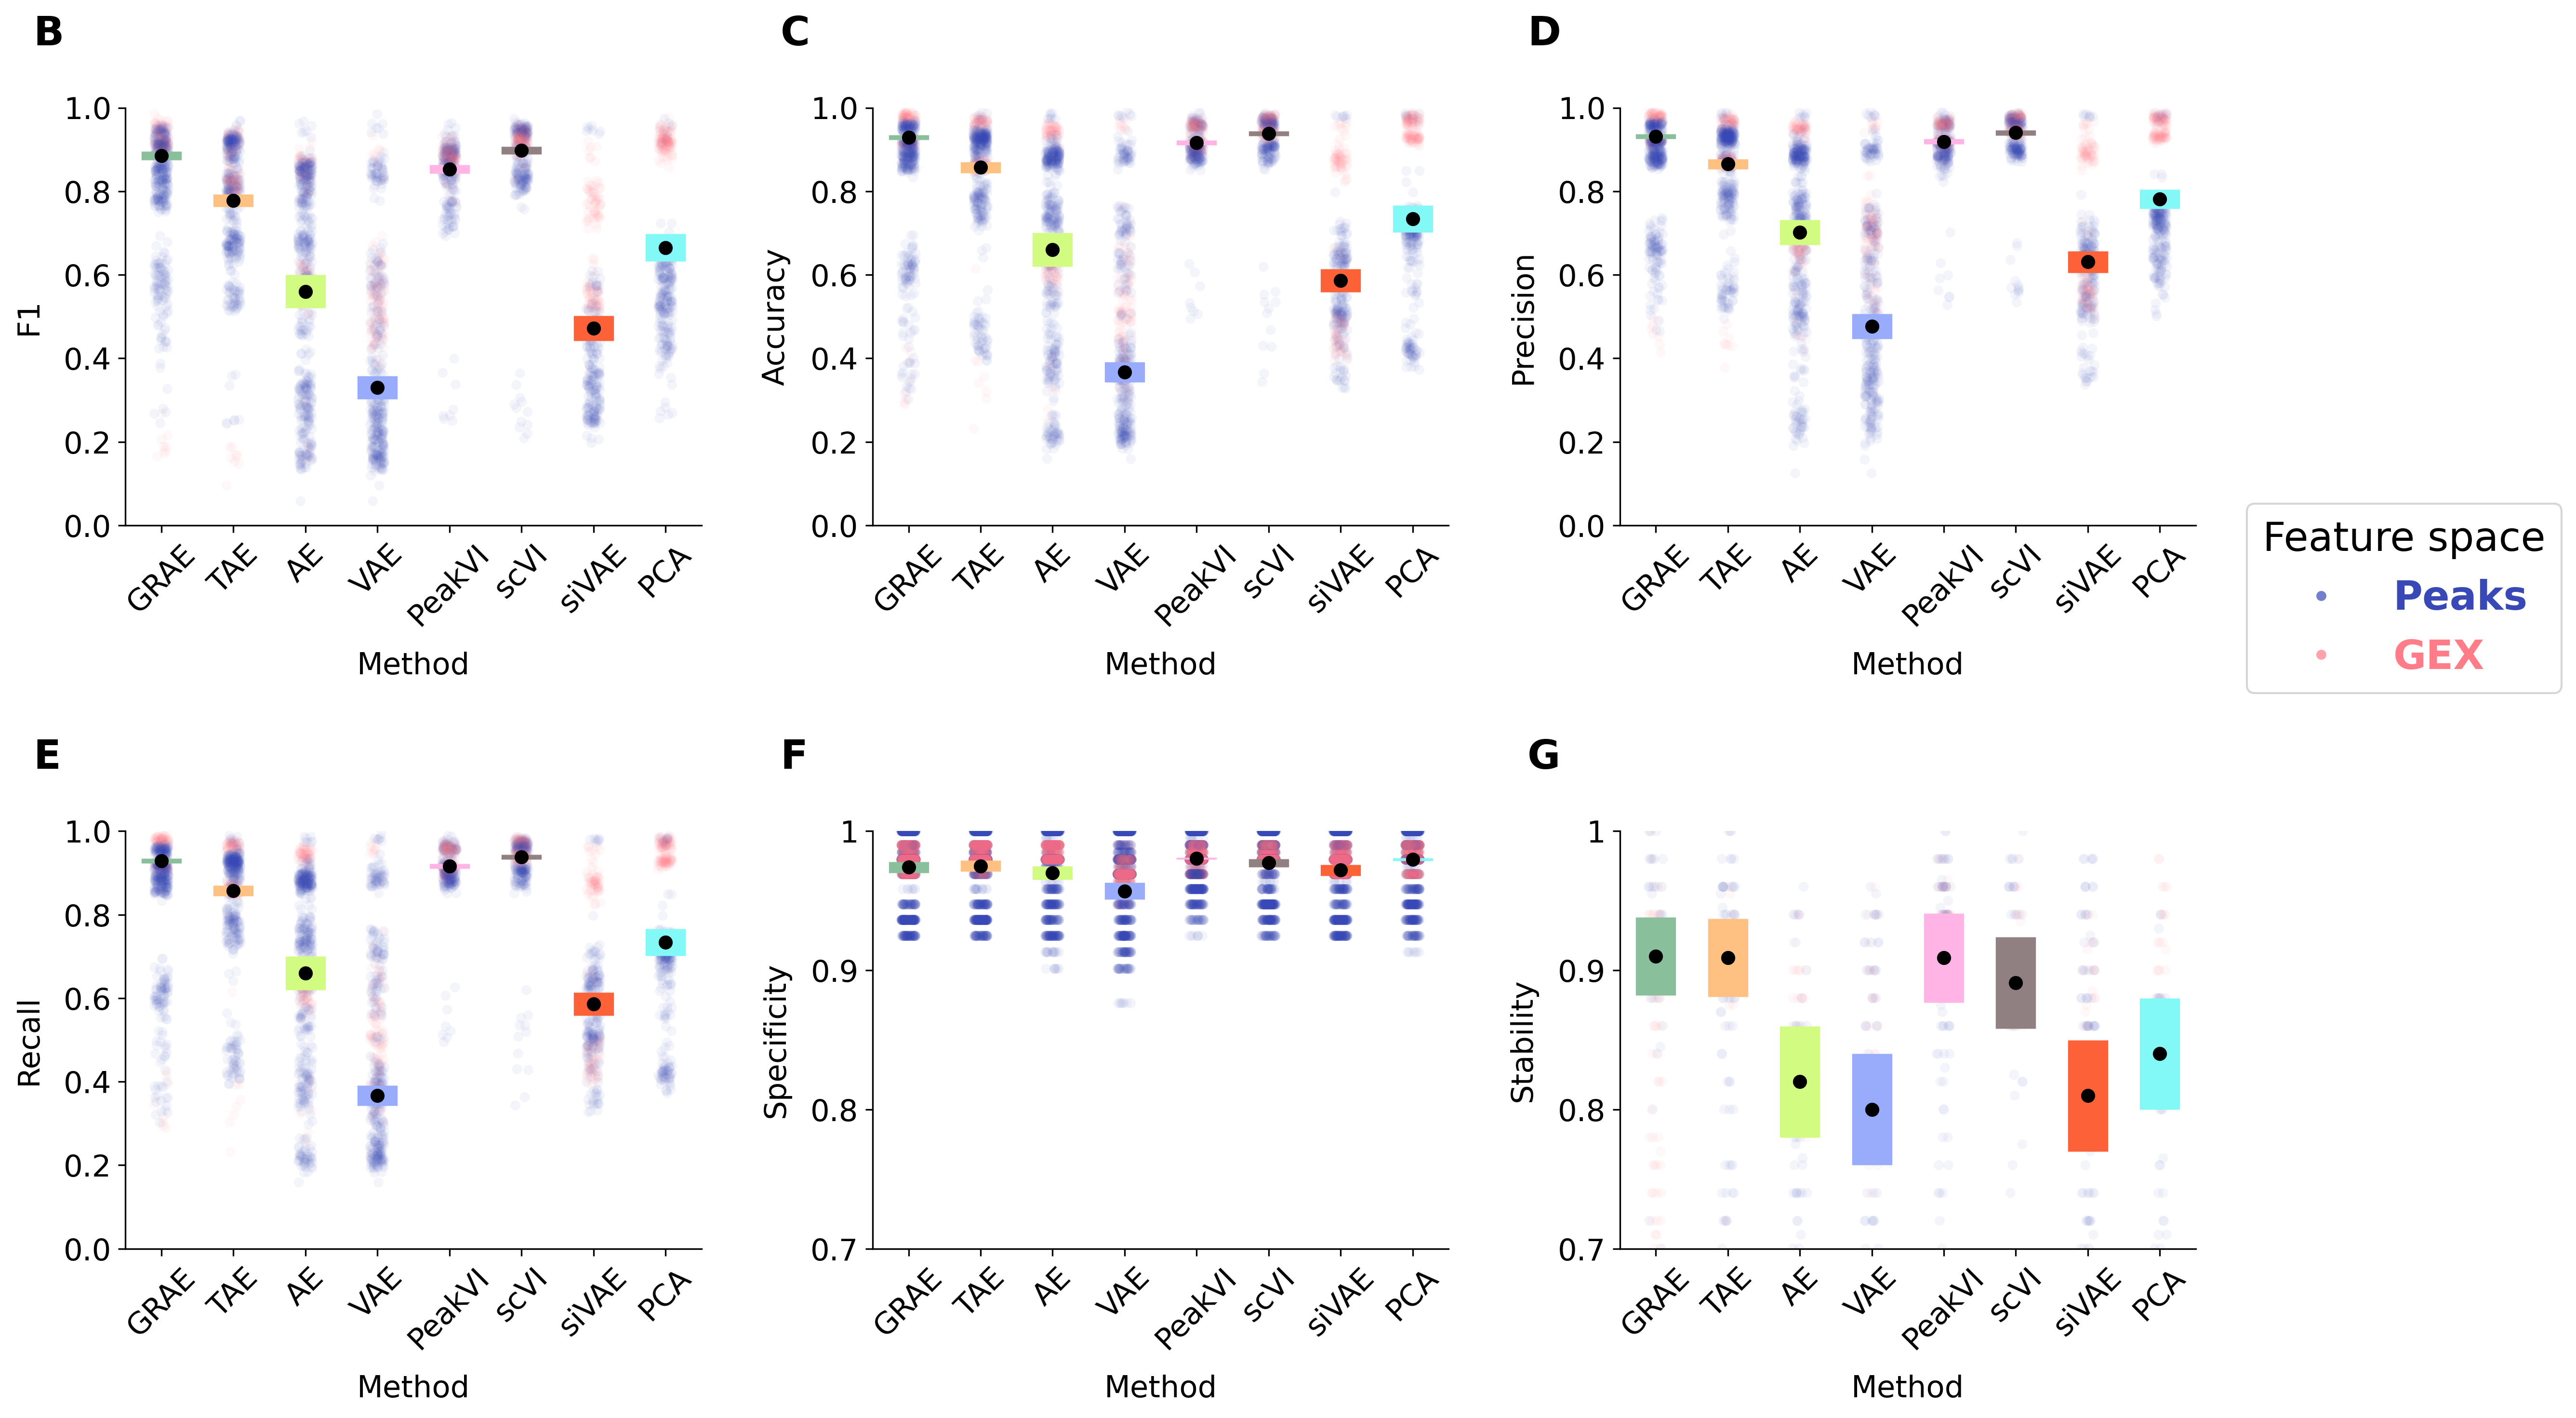

In [7]:
params = {'axes.labelsize': 15,
         'axes.titlesize': 15,
         'xtick.labelsize' : 15,
         'ytick.labelsize': 15,
         "lines.linewidth" : 4,
         "figure.dpi" : 300,
         "figure.figsize": [18, 10]}
plt.rcParams.update(params)
fs_order=["Peaks", "GEX"]

t=tot[tot["GNN"]=="GAT"]
t["FeaturesSpace"]=t["FeaturesSpace"].str.replace("Peak","Peaks")
fig, axs = plt.subplots(2,3)
axs=axs.flatten()
for i, metric in enumerate(["F1","Accuracy","Precision","Recall","Specificity","Stability"]):
    means=[float(i.split(u"\u00B1")[0]) for i in np.array(defd[metric])]
    sems=[float(i.split(u"\u00B1")[1]) for i in np.array(defd[metric])]
    axs[i].errorbar(x=AEs_order, y=means, yerr=sems,ls='none', ecolor=palette.values(), 
                    elinewidth=20, marker="o", c="black", zorder=10)
  
    strip=sns.stripplot(data=t, x="Representation", y=metric, hue="FeaturesSpace", ax=axs[i], alpha=0.05, 
                        palette=feats_palette, zorder=1)
 
    if i == 2:
        handles, labels = strip.get_legend_handles_labels()
        legend_properties = {'weight':'bold', "size" :20}
        title_fontproperties = {"size" : 20 }
        leg=strip.legend(handles, labels, bbox_to_anchor=(1.67, 0.1), title="Feature space", 
                     labelcolor=list(feats_palette.values()), prop=legend_properties, title_fontproperties=title_fontproperties)    
        leg.legend_handles[0].set_alpha(0.7)
        leg.legend_handles[1].set_alpha(0.7)
    else:
        axs[i].get_legend().remove()  
    
    axs[i].set_ylabel(metric, rotation=90, labelpad=10)
    axs[i].set_xticks(axs[i].get_xticks(), AEs_order, size=15, rotation=45)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)    
    axs[i].text(-0.16, 1.15, string.ascii_uppercase[i+1], transform=axs[i].transAxes, size=20, weight='bold',rotation=0)    
    axs[i].set_xlabel('Method', rotation=0, labelpad=10)
    axs[i].set_ylim([0,1])
    yticks=np.around(np.linspace(0, 1, 6), 1)
    axs[i].set_yticks(yticks, yticks)
    if i > 3:
        axs[i].set_ylim([0.7, 1])
        yticks=[0.7, 0.8, 0.9, 1]
        axs[i].set_yticks(yticks, yticks)
    i+=1    
        
fig.tight_layout(h_pad=2, w_pad=3)
plt.savefig("Figures/SEAGALL_Fig4.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

## SEAGALL_SuppFig5

In [9]:
cl=pd.read_csv("Tables/ClassficationMetrics.tsv.gz", sep="\t")
print(cl.shape)
stab=pd.read_csv("Tables/Stability.tsv.gz", sep="\t")
print(stab.shape)
spec=pd.read_csv("Tables/Specificity.tsv.gz", sep="\t")
print(spec.shape)
tot=pd.concat([cl, stab, spec])
print(tot.shape)
tot["Dataset"]=tot["Dataset"].str.replace("_H","").str.replace("_M","")
order=["GAT","GCN"]
d=pd.DataFrame()
t=tot[tot["Representation"]=="GRAE"]
for metric in ["F1W","F1M","Accuracy","Precision","Recall","Stability","Specificity"]:
    gnns=list(t[[metric,"GNN"]].groupby("GNN")[metric].mean().index)
    mean=np.array(t[[metric,"GNN"]].dropna().groupby("GNN")[metric].mean())
    sem=np.array(3*t[[metric,"GNN"]].dropna().groupby("GNN")[metric].sem())
    for g, m, s in zip(gnns, mean, sem):
        d=pd.concat([d, pd.DataFrame([metric, g, str(uncertainties.ufloat(m, s))], index=["Metric", "GNN", "Mean +- 3*SEM"]).T], axis=0)
defd=d.pivot(index="GNN", columns="Metric", values="Mean +- 3*SEM").loc[order]
for col in defd.columns:
    defd[col]=defd[col].str.replace("+/-",u"\u00B1")

(4468, 9)
(795, 6)
(39434, 6)
(44697, 12)


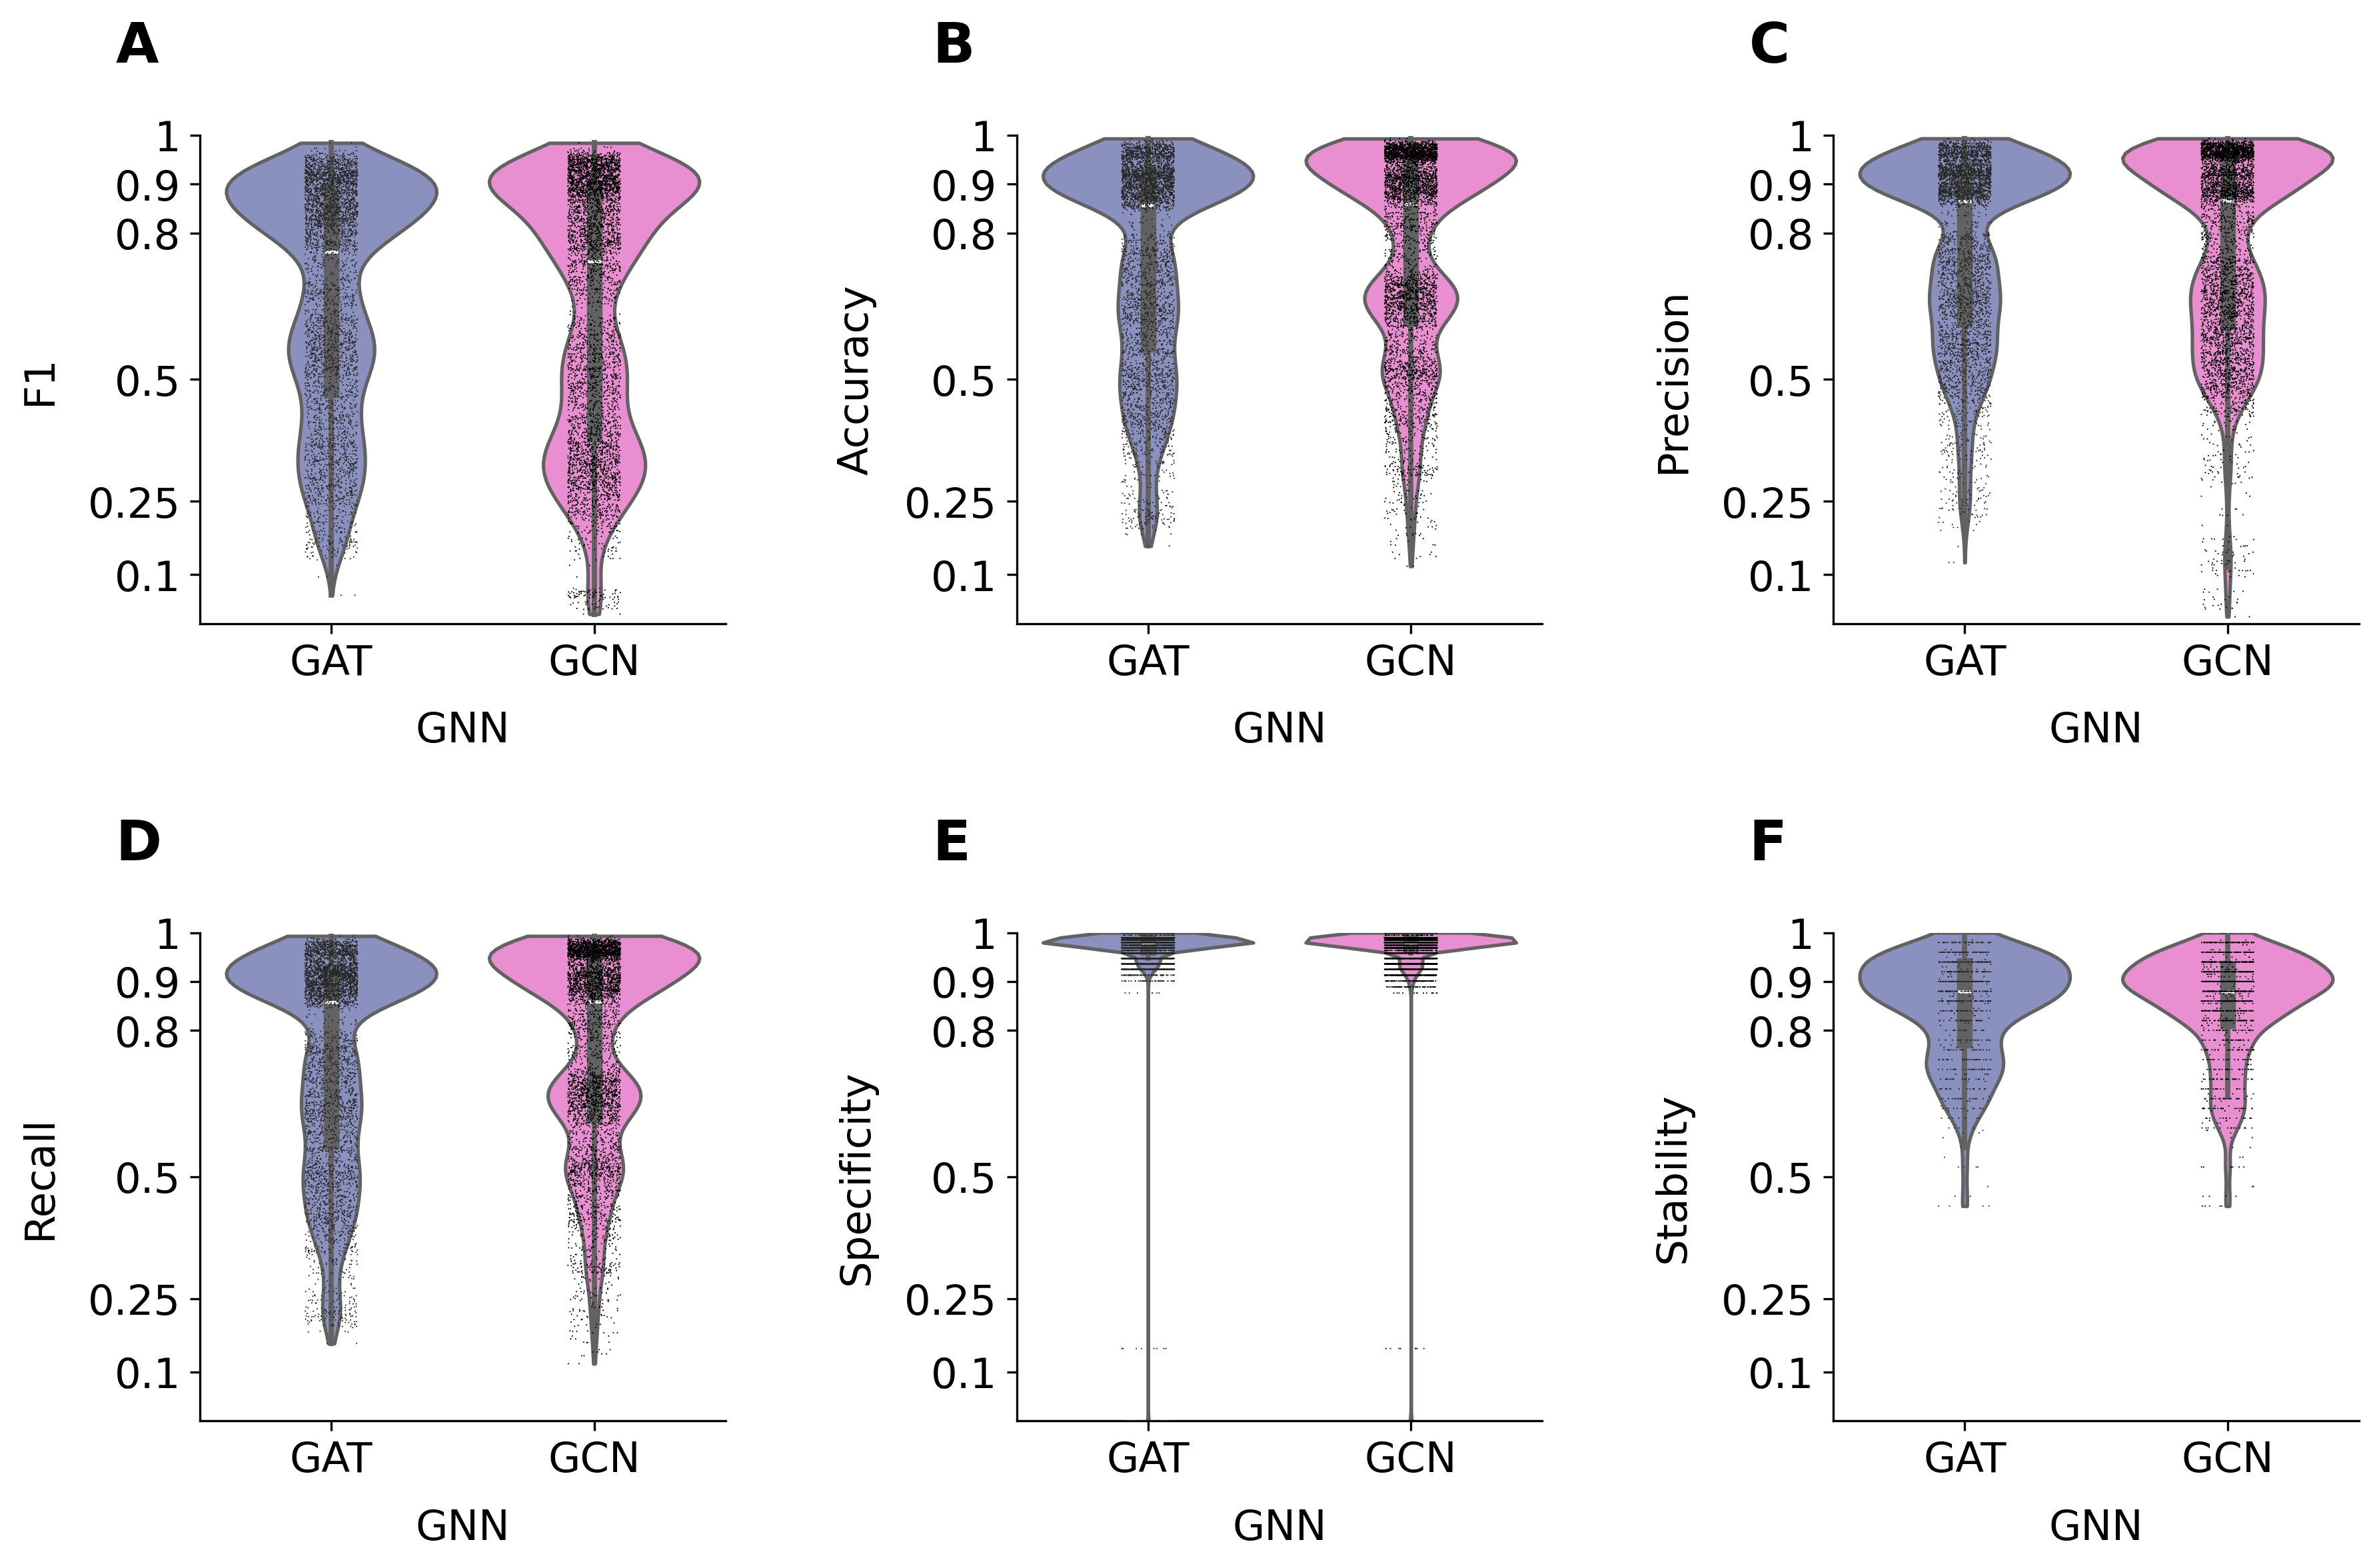

In [10]:
params = {'axes.labelsize': 15,
         'axes.titlesize': 15,
         'xtick.labelsize' : 15,
         'ytick.labelsize': 15,
         "lines.linewidth" : 4,
         "figure.dpi" : 300,
         "figure.figsize": [12, 8]}
plt.rcParams.update(params)
hue_order=["GAT","GCN"]

new_colors=[ut.colors_to_use_pastel[7]] + [ut.colors_to_use_pastel[-1]]

fig, axs = plt.subplots(2,3)
axs=axs.flatten()
for i, metric in enumerate(["F1M","Accuracy","Precision","Recall","Specificity","Stability"]):
    sns.violinplot(data=tot, y=metric, x="GNN", hue="GNN", hue_order=hue_order, ax=axs[i], palette=new_colors, cut=0)
    sns.stripplot(data=tot, y=metric, x="GNN", hue="GNN", color="black", ax=axs[i], size=0.5)
    axs[i].set_ylabel(metric, rotation=90, labelpad=10)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)    
    axs[i].text(-0.16, 1.15, string.ascii_uppercase[i], transform=axs[i].transAxes, size=20, weight='bold',rotation=0)    
    axs[i].set_xlabel('GNN', rotation=0, labelpad=10)
    axs[i].set_ylim([0,1])
    yticks=[0.10, 0.25, 0.5, 0.8, 0.9, 1]
    axs[i].set_yticks(yticks, yticks)
    i+=1
axs[0].set_ylabel("F1")
fig.tight_layout(h_pad=2, w_pad=4)
plt.savefig("Figures/SEAGALL_SuppFig5.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

## SEAGALL_SuppFig6

In [ ]:
ds="GSE117309"
fs="Window"
lab="BCsubtype"
gnn="GAT"
rep="GRAE"
tot=pd.DataFrame(columns=["Representation","GNN","Accuracy","Precision","Recall","F1W","F1M","Dataset","FeaturesSpace"])
for run in range(0,50):
    file=f"Datasets/{ds}/FeatureSpaces/{fs}/MS/Run{run}/{ds}_{fs}_{rep}_{gnn}_Predictions.tsv.gz"
    if os.path.isfile(file) == True:               
        df=pd.read_csv(file, sep="\t", index_col=0)
        df=df[df["GNN_set"]=="Test"]
        acc=np.around(df[df[lab]==df["GNN_prediction"]].shape[0]/df.shape[0], decimals=4)
        f1=sklearn.metrics.precision_recall_fscore_support(df[lab], df.GNN_prediction, average="weighted")
        f1m=sklearn.metrics.precision_recall_fscore_support(df[lab], df.GNN_prediction, average="macro")[2]
        to_append=pd.DataFrame(index=tot.columns, data=[rep, gnn, acc] + [f for f in np.array(f1[:3])]+[f1m, "Breast cancer", fs]).T
        tot=pd.concat([tot, to_append])
    else:
        print(file)  
tot["F1W"]=tot["F1W"].astype(float)
tot["F1M"]=tot["F1M"].astype(float)
tot["Accuracy"]=tot["Accuracy"].astype(float)
tot["Precision"]=tot["Precision"].astype(float)
tot["Recall"]=tot["Recall"].astype(float)
tot.reset_index(inplace=True)
tot.drop("index", axis=1, inplace=True)
tot.to_csv("Tables/ClassficationMetricsChIPseq.tsv.gz", sep="\t", index=None, compression="gzip")
tot.head()

In [ ]:
ds="GSE117309"
fs="Window"
lab="BCsubtype"
gnn="GAT"
rep="GRAE"

tot=pd.DataFrame(columns=["GNN","Representation","celltype","Stability","Dataset","FeaturesSpace"])
dfs=[]
for run in range(0, 50):
    file=f"Datasets/{ds}/FeatureSpaces/{fs}/MS/Run{run}/{ds}_{fs}_{rep}_{gnn}_XAITop50Features.tsv.gz"
    if os.path.isfile(file) != False:
        dfs.append(pd.read_csv(file, index_col=0, sep="\t"))   
    else:
        print(file)
if len(dfs)!=0:
    expls={}
    for col in dfs[0].columns:
        expls[col]=[list(df[col]) for df in dfs]

    stabs=[]
    for key in expls.keys():
        t=pd.DataFrame(expls[key])
        table=pd.DataFrame(index=range(0, len(dfs)), columns=range(0, len(dfs)))
        for n in range(0, len(dfs)):
            for k in range(n, len(dfs)):
                table.at[n,k]=len(ut.intersection([t.iloc[n],t.iloc[k]]))/50
                table.at[k,n]=table.at[n,k]
        stabs.append(table.median().median())
    
    d=pd.DataFrame(index=tot.columns).T
    d["celltype"]=expls.keys()
    d["Stability"]=stabs
    d["GNN"]=gnn
    d["Representation"]=rep
    d["Dataset"]="Breast cancer"
    d["FeaturesSpace"]=fs
    tot=pd.concat([tot, d])
tot.reset_index(inplace=True)
tot.drop("index", axis=1, inplace=True)
tot.to_csv("Tables/StabilityChIPseq.tsv.gz", sep="\t", index=None, compression="gzip")
tot.head()

In [ ]:
ds="GSE117309"
fs="Window"
lab="BCsubtype"
gnn="GAT"
rep="GRAE"

tot=pd.DataFrame(columns=["GNN","Representation","celltype","Specificity","Dataset","FeaturesSpace"])
data=pd.DataFrame(columns=tot.columns)    
for run in range(0, 50):
    file=f"Datasets/{ds}/FeatureSpaces/{fs}/MS/Run{run}/{ds}_{fs}_{rep}_{gnn}_XAITop50Features_Jaccard.tsv.gz"
    if os.path.isfile(file) != False: 
        df=pd.read_csv(file, sep="\t", index_col=0)
        d=pd.DataFrame(index=data.columns).T
        d["celltype"]=df.columns
        d["GNN"]=gnn
        d["Representation"]=rep
        d["Specificity"]=np.array(1-np.median(df))
        d["Dataset"]="Breast cancer"
        d["FeaturesSpace"]=fs
        tot=pd.concat([tot, d])
    else:
        print(file)
tot.reset_index(inplace=True)
tot.drop("index", axis=1, inplace=True)
tot.to_csv("Tables/SpecificityChIPseq.tsv.gz", sep="\t", index=None, compression="gzip")
tot.head()

In [11]:
cl=pd.read_csv("Tables/ClassficationMetricsChIPseq.tsv.gz", sep="\t")
stab=pd.read_csv("Tables/StabilityChIPseq.tsv.gz", sep="\t")
spec=pd.read_csv("Tables/SpecificityChIPseq.tsv.gz", sep="\t")
tot=pd.concat([cl, stab, spec])
tot["Dataset"]=tot["Dataset"].str.replace("_H","").str.replace("_M","")
tot.rename({"F1M" : "F1"}, axis=1, inplace=True)
order=["GRAE"]
d=pd.DataFrame()
for metric in ["F1","Accuracy","Precision","Recall","Stability","Specificity"]:
    t=tot[tot["GNN"]=="GAT"]
    mean=np.array(t[[metric,"Representation"]].dropna().groupby("Representation")[metric].mean().loc[order])
    sem=np.array(3*t[[metric,"Representation"]].dropna().groupby("Representation")[metric].sem().loc[order])
    for ae, m, s in zip(order, mean, sem):
        d=pd.concat([d, pd.DataFrame([metric, ae, str(uncertainties.ufloat(m, s))], index=["Metric", "DR method", "Mean +- 3*SEM"]).T], axis=0)
defd=d.pivot(index="DR method", columns="Metric", values="Mean +- 3*SEM").loc[order]
for col in defd.columns:
    defd[col]=defd[col].str.replace("+/-",u"\u00B1")
defd

Metric,Accuracy,F1,Precision,Recall,Specificity,Stability
DR method,,,,,,
GRAE,0.781±0.016,0.722±0.013,0.786±0.013,0.781±0.016,0.9413±0.0033,0.77±0.07


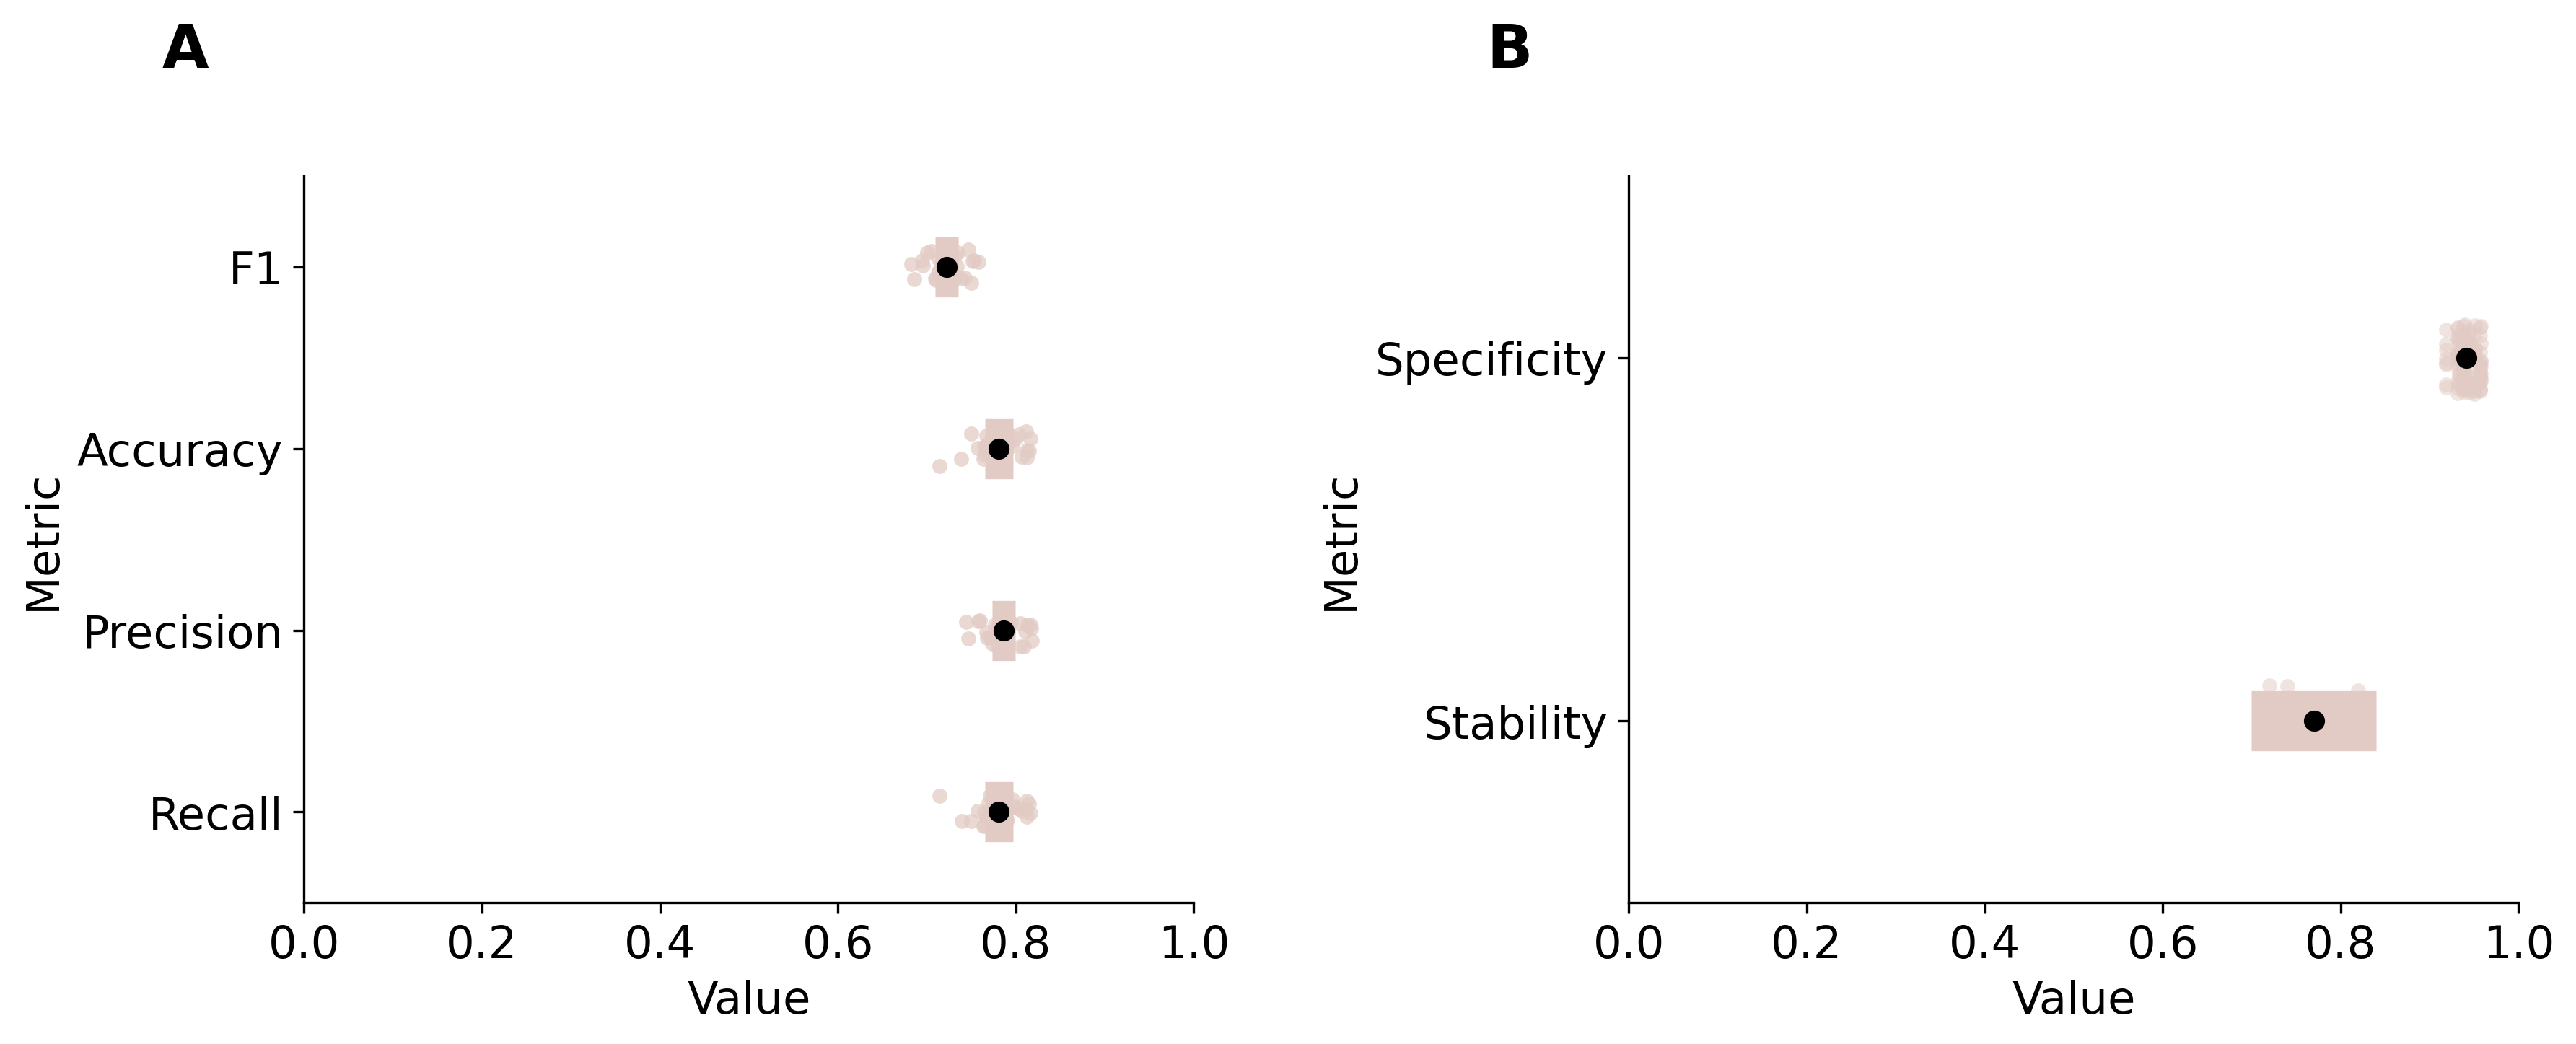

In [15]:
params = {'axes.labelsize': 15,
         'axes.titlesize': 15,
         'xtick.labelsize' : 15,
         'ytick.labelsize': 15,
         "lines.linewidth" : 4,
         "figure.dpi" : 300,
         "figure.figsize": [12, 5]}
plt.rcParams.update(params)

t=tot[tot["GNN"]=="GAT"]
t["FeaturesSpace"]="Windows"
fig, axs = plt.subplots(1,2)
axs=axs.flatten()
for i, metric in enumerate(["F1","Accuracy","Precision","Recall","Specificity","Stability"]):
    means=[float(i.split(u"\u00B1")[0]) for i in np.array(defd[metric])]
    sems=[float(i.split(u"\u00B1")[1]) for i in np.array(defd[metric])]
    ax = axs[0] if i < 4 else axs[1]
    ax.errorbar(y=metric, x=means, xerr=sems,ls='none', ecolor=feats_palette["Windows"], elinewidth=20, marker="o", c="black", zorder=10)

d=t[["F1","Accuracy","Precision","Recall"]].dropna().melt()
sns.stripplot(data=d, x="value", y="variable", ax=axs[0], alpha=0.75, color=feats_palette["Windows"], zorder=1)

d=t[["Specificity","Stability"]].melt()
sns.stripplot(data=d, x="value", y="variable", ax=axs[1], alpha=0.5, color=feats_palette["Windows"], zorder=1)

for i, ax in enumerate(axs):    
    ax.set_ylabel("Metric")
    ax.set_xlabel("Value")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    
    ax.text(-0.16, 1.15, string.ascii_uppercase[i], transform=axs[i].transAxes, size=20, weight='bold',rotation=0)    
    ax.set_xlim([0,1])
    xticks=np.around(np.linspace(0, 1, 6), 1)
    ax.set_xticks(xticks, xticks)
        
fig.tight_layout(h_pad=2, w_pad=3)
plt.savefig("Figures/SEAGALL_SuppFig6.png", format="png", dpi=300, bbox_inches='tight')
plt.show()